# Fully-Connected Neural Network with Batch Normalization
Two layers of fully connected nerual network.
Adapated based on cs231n project

Activation function uses Rectified Linear Unit [(ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

To help activations pass through layers of network, [Batch Normalization](jmlr.org/proceedings/papers/v37/ioffe15.pdf) layer is added to center and normalize the activations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utilities.data_utils import *
from utilities.solver import Solver

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load preprocessed CIFAR-10 data
# Mean image has been substracted from test, validation and training
# images to normalize the data
# Images has been flatten to NxD (N test cases, D features)
data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3072)
X_train:  (49000, 3072)
y_train:  (49000,)
X_test:  (1000, 3072)
y_val:  (1000,)
y_dev:  (100,)
X_dev:  (100, 3072)
y_test:  (1000,)


In [3]:
# Define FC layer (affine), ReLU, batchnorm
# Both forward and backward pass

def affine_forward(x, w, b):
  """
  Computes the forward pass for an affine (fully-connected) layer.

  Inputs:
  - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
  - w: A numpy array of weights, of shape (D, M)
  - b: A numpy array of biases, of shape (M,)
  
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """
  out = None
  N = x.shape[0]
  x_mat = x.reshape(N, -1)
  out = np.dot(x_mat, w) + b
  cache = (x, w, b)
  return out, cache


def affine_backward(dout, cache):
  """
  Computes the backward pass for an affine layer.

  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)

  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  N = x.shape[0]
  x_mat = x.reshape(N, -1)
  dx = dout.dot(w.T).reshape(*x.shape)
  dw = x_mat.T.dot(dout)
  db = np.sum(dout, axis=0)
  return dx, dw, db


def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).

  Input:
  - x: Inputs, of any shape

  Returns a tuple of:
  - out: Output, of the same shape as x
  - cache: x
  """
  out = x.copy()
  out[out<=0] = 0
  cache = x
  return out, cache


def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).

  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout

  Returns:
  - dx: Gradient with respect to x
  """
  dx, x = None, cache
  dx = dout.copy()
  dx[x<=0] = 0
  return dx


def batchnorm_forward(x, gamma, beta, bn_param):
  """
  Forward pass for batch normalization.

  running_mean = momentum * running_mean + (1 - momentum) * sample_mean
  running_var = momentum * running_var + (1 - momentum) * sample_var

  Input:
  - x: Data of shape (N, D)
  - gamma: Scale parameter of shape (D,)
  - beta: Shift paremeter of shape (D,)
  - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features

  Returns a tuple of:
  - out: of shape (N, D)
  - cache: A tuple of values needed in the backward pass
  """
  mode = bn_param['mode']
  eps = bn_param.get('eps', 1e-5)
  momentum = bn_param.get('momentum', 0.9)

  N, D = x.shape
  running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
  running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

  out, cache = None, None
  if mode == 'train':
    x_mean = np.mean(x, axis=0)
    x_var = np.var(x, axis=0)
    running_mean = momentum * running_mean + (1 - momentum) * x_mean
    running_var = momentum * running_var + (1 - momentum) * x_var
    x_nom = (x - x_mean) / np.sqrt(x_var + eps)
    out = gamma * x_nom + beta
    cache = x, x_nom, x_mean, x_var, gamma, beta, eps

  elif mode == 'test':
    out = (x - running_mean) / np.sqrt(running_var + eps)
    out = gamma * out + beta
  else:
    raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

  # Store the updated running means back into bn_param
  bn_param['running_mean'] = running_mean
  bn_param['running_var'] = running_var

  return out, cache


def batchnorm_backward(dout, cache):
  """
  Backward pass for batch normalization.

  
  Inputs:
  - dout: Upstream derivatives, of shape (N, D)
  - cache: Variable of intermediates from batchnorm_forward.
  
  Returns a tuple of:
  - dx: Gradient with respect to inputs x, of shape (N, D)
  - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
  - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
  """
  dx, dgamma, dbeta = None, None, None
  x, x_nom, x_mean, x_var, gamma, beta, eps = cache
  m = x.shape[0]
  dgamma = np.sum(dout * x_nom, axis=0)
  dbeta = np.sum(dout, axis=0)
  dx_nom = dout * gamma
  d_var = np.sum(dx_nom * (x - x_mean) * (-0.5) * ((x_var + eps) ** (-1.5)), axis=0)
  d_mean = np.sum(dx_nom * -1/np.sqrt(x_var + eps), axis=0) + d_var * np.sum(2*(x_mean - x), axis=0)/m
  dx = dx_nom * 1/np.sqrt(x_var + eps) + d_var * 2*(x - x_mean)/m + d_mean/m

  return dx, dgamma, dbeta

def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx

In [4]:
# Create two layer neural network: FC --> BatchNorm --> ReLU --> FC --> Softmax
# Neural Network construction will be wrappered in a class in later projects
# Here two layers means the two FC layers. BatchNorm are for data initialization purpose
# ReLU adds nonlinear function to the network


# In this project, parameter initialization (random numbers for weights) is 
# done outside the class. This is for exercise purpose, it is not idea
# Next one I will encapsulate the random number generation in initializer

class TwoLayerNet(object):
    """
    Two layer fully connected neural network
    FC layer -> Batchnorm -> ReLU nonlinear -> FC layer -> Softmax
    """
    
    def __init__(self, w1, b1, w2, b2, gamma, beta,
        weight_scale=1e-3, reg=0.0, verbose=False, dtype=np.float32):
        self.params = {}
        self.bn_params = {}
        self.verbose = verbose
        self.params["W1"] = w1
        self.params["b1"] = b1
        self.params["W2"] = w2
        self.params["b2"] = b2
        self.params["gamma"] = gamma
        self.params["beta"] = beta
        self.ws = weight_scale
        self.reg = reg
        self.dtype = dtype
        
        for k, v in sorted(self.params.iteritems()):
            #if verbose: print "params %s, shape %s" % (k, v.shape)
            self.params[k] = v.astype(self.dtype)
            
                
                
    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the network
        
        Inputs:
        - X: Array of input data of shape (N, *input_dim)
        - y: Array of labels, of shape (N,), y[i] gives the label for X[i]
        
        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N,C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.
          
        If y is not None, then runa a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        ########################################################
        # Forward pass
        ########################################################
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'
        self.bn_params['mode'] = mode
        caches = []
        # FC 1
        a1, cache = affine_forward(X, self.params["W1"], self.params["b1"])
        caches.append(cache)
        # Batch Normalization
        a_bn1, cache = batchnorm_forward(a1, self.params["gamma"], self.params["beta"], self.bn_params)
        caches.append(cache)
        # ReLU
        a_relu1, cache = relu_forward(a_bn1)
        caches.append(cache)
        # FC 2
        scores, cache = affine_forward(a_relu1, self.params["W2"], self.params["b2"])
        caches.append(cache)
        
        if mode == 'test':
            return scores
        
        ########################################################
        # Backward propagation
        ########################################################
        loss, grads = 0.0, {}
        loss, dout = softmax_loss(scores, y)
        # add regularization
        loss += 0.5 * self.reg * ( np.sum(self.params['W1']**2) + np.sum(self.params['W2']**2) )
        
        # back propagate gradient        
        # last affine layer
        cache = caches.pop()
        dout, dW, db = affine_backward(dout, cache)
        grads['W2'] = dW + self.reg * self.params['W2']
        grads['b2'] = db
        # ReLU
        cache = caches.pop()
        dout = relu_backward(dout, cache)
        # Batch Normalization
        cache = caches.pop()
        dout, dgamma, dbeta = batchnorm_backward(dout, cache)
        grads['gamma'] = dgamma
        grads['beta'] = dbeta
        # FC 1
        cache = caches.pop()
        dout, dW, db = affine_backward(dout, cache)
        grads['W1'] = dW + self.reg * self.params['W1']
        grads['b1'] = db
        
        return loss, grads




In [5]:
# Create a small network to validate gradient calculation

N, D, H1, H2, C = 5, 10, 6, 8, 6   # number of test cases, features, number of hidden unit, number of classes
y = np.random.randint(C, size=N)
x = np.random.randn(N, D)
w1 = 0.001 * np.random.randn(D, H1)
b1 = np.random.randn(H1)
w2 = 0.001 * np.random.randn(H1, H2)
b2 = np.random.randn(H2)
gamma = np.ones(H1)
beta = np.zeros(H1)

# with regularzation turned off
model = TwoLayerNet(w1, b1, w2, b2, gamma, beta,
        weight_scale=0.03, reg=0.00, verbose=True, dtype=np.float64)

loss, grads = model.loss(x, y)
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

for name in sorted(grads):
   f = lambda _: model.loss(x, y)[0]
   grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
   print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

# With regularization turned on
print "\nWith regularization turned on:"
model2 = TwoLayerNet(w1, b1, w2, b2, gamma, beta,
        weight_scale=0.03, reg=0.6, verbose=True, dtype=np.float64)

loss, grads = model2.loss(x, y)

for name in sorted(grads):
   f = lambda _: model2.loss(x, y)[0]
   grad_num = eval_numerical_gradient(f, model2.params[name], verbose=False)
   print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

W1 relative error: 4.70e-06
W2 relative error: 1.60e-09
b1 relative error: 2.08e-09
b2 relative error: 2.49e-10
beta relative error: 2.64e-07
gamma relative error: 8.44e-08

With regularization turned on:
W1 relative error: 6.42e-06
W2 relative error: 1.34e-09
b1 relative error: 2.08e-09
b2 relative error: 2.49e-10
beta relative error: 2.64e-07
gamma relative error: 8.44e-08


In [6]:
# Declare network for Cifar10
D, H1, H2, C = 3072, 100, 100, 10   # number of test cases, features, number of hidden unit, number of classes

w1 = 0.001 * np.random.randn(D, H1)
b1 = np.random.randn(H1)
w2 = 0.001 * np.random.randn(H1, H2)
b2 = np.random.randn(H2)
gamma = np.ones(H1)
beta = np.zeros(H1)

model = TwoLayerNet(w1, b1, w2, b2, gamma, beta,
        weight_scale=0.03, reg=0.0001, verbose=True, dtype=np.float64)


In [7]:
solver = Solver(model, data,
                 update_rule='adam',
                 optim_config={
                   'learning_rate': 1e-3,
                  },
                  lr_decay=0.95,
                  num_epochs=10, batch_size=100,
                print_every=100)
solver.train()

(Iteration 1 / 4900) loss: 4.807757
(Epoch 0 / 10) train acc: 0.161000; val_acc: 0.173000
(Iteration 101 / 4900) loss: 1.969828
(Iteration 201 / 4900) loss: 1.788941
(Iteration 301 / 4900) loss: 1.787009
(Iteration 401 / 4900) loss: 1.657621
(Epoch 1 / 10) train acc: 0.449000; val_acc: 0.428000
(Iteration 501 / 4900) loss: 1.620931
(Iteration 601 / 4900) loss: 1.608835
(Iteration 701 / 4900) loss: 1.579913
(Iteration 801 / 4900) loss: 1.603053
(Iteration 901 / 4900) loss: 1.413051
(Epoch 2 / 10) train acc: 0.496000; val_acc: 0.442000
(Iteration 1001 / 4900) loss: 1.553973
(Iteration 1101 / 4900) loss: 1.341107
(Iteration 1201 / 4900) loss: 1.440078
(Iteration 1301 / 4900) loss: 1.478979
(Iteration 1401 / 4900) loss: 1.365082
(Epoch 3 / 10) train acc: 0.535000; val_acc: 0.488000
(Iteration 1501 / 4900) loss: 1.369063
(Iteration 1601 / 4900) loss: 1.370673
(Iteration 1701 / 4900) loss: 1.227712
(Iteration 1801 / 4900) loss: 1.586937
(Iteration 1901 / 4900) loss: 1.439272
(Epoch 4 / 10) t

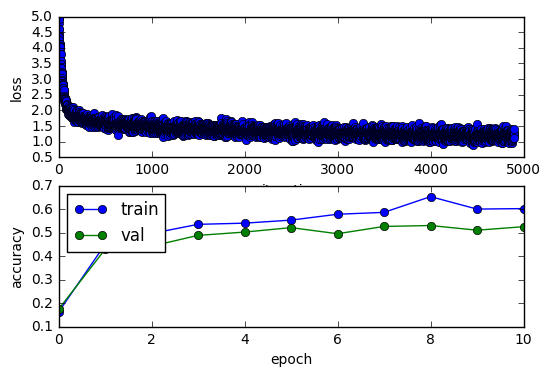

In [8]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [9]:
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

Validation set accuracy:  0.529
Test set accuracy:  0.533
